In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [2]:
data = pd.read_csv("dccc_prepared.csv")
data.head()

,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,0.080808,0.333333,0.666667,0.224138,0.2,0.2,0.2,0.2,0.2,0.2,...,0.173637,0.095470,0.272928,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458,0
1,0.040404,0.333333,0.333333,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.186809,0.109363,0.283685,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892,0
2,0.040404,0.333333,0.333333,0.620690,0.1,0.2,0.1,0.2,0.2,0.2,...,0.179863,0.099633,0.275681,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284,0
3,0.040404,0.166667,0.666667,0.275862,0.2,0.2,0.2,0.2,0.2,0.2,...,0.178407,0.100102,0.276367,0.002862,0.001078,0.000733,0.001610,0.002345,0.001513,0
4,0.494949,0.166667,0.666667,0.137931,0.2,0.2,0.2,0.2,0.2,0.2,...,0.671310,0.559578,0.625196,0.062961,0.023749,0.042409,0.032591,0.032237,0.026047,0


In [3]:
X = data.iloc[:,:-1]
y = data["default payment next month"]

In [4]:
X_new, X_test, y_new, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
dev_per = X_test.shape[0]/X_new.shape[0]
X_train, X_dev, y_train, y_dev = train_test_split(X_new, y_new, test_size=dev_per, random_state=0)

In [5]:
print("Training sets:",X_train.shape, y_train.shape)
print("Validation sets:",X_dev.shape, y_dev.shape)
print("Testing sets:",X_test.shape, y_test.shape)

Training sets: (28036, 22) (28036,)
Validation sets: (9346, 22) (9346,)
Testing sets: (9346, 22) (9346,)


In [6]:
X_dev_torch = torch.tensor(X_dev.values).float()
y_dev_torch = torch.tensor(y_dev.values)
X_test_torch = torch.tensor(X_test.values).float()
y_test_torch = torch.tensor(y_test.values)

In [7]:
class Classifier(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.hidden_1 = nn.Linear(input_size, 10)
        self.hidden_2 = nn.Linear(10, 10)
        self.hidden_3 = nn.Linear(10, 10)
        self.output = nn.Linear(10, 2)
        
    def forward(self, x):
        z = F.relu(self.hidden_1(x))
        z = F.relu(self.hidden_2(z))
        z = F.relu(self.hidden_3(z))
        out = F.log_softmax(self.output(z), dim=1)
        
        return out

In [8]:
model = Classifier(X_train.shape[1])
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 50
batch_size = 128

In [9]:
train_losses, dev_losses, train_acc, dev_acc= [], [], [], []

for e in range(epochs):
    X_, y_ = shuffle(X_train, y_train)
    running_loss = 0
    running_acc = 0
    iterations = 0
    
    for i in range(0, len(X_), batch_size):
        iterations += 1
        b = i + batch_size
        X_batch = torch.tensor(X_.iloc[i:b,:].values).float()
        y_batch = torch.tensor(y_.iloc[i:b].values)
        
        log_ps = model(X_batch)
        loss = criterion(log_ps, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        running_acc += accuracy_score(y_batch, top_class)
        
    dev_loss = 0
    acc = 0

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        log_dev = model(X_dev_torch)
        dev_loss = criterion(log_dev, y_dev_torch)

        ps_dev = torch.exp(log_dev)
        top_p, top_class_dev = ps_dev.topk(1, dim=1)
        acc = accuracy_score(y_dev_torch, top_class_dev)

    train_losses.append(running_loss/iterations)
    dev_losses.append(dev_loss)
    train_acc.append(running_acc/iterations)
    dev_acc.append(acc)

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/iterations),
          "Validation Loss: {:.3f}.. ".format(dev_loss),
          "Training Accuracy: {:.3f}.. ".format(running_acc/iterations),
          "Validation Accuracy: {:.3f}".format(acc))

Epoch: 1/50..  Training Loss: 0.672..  Validation Loss: 0.630..  Training Accuracy: 0.594..  Validation Accuracy: 0.640
Epoch: 2/50..  Training Loss: 0.617..  Validation Loss: 0.611..  Training Accuracy: 0.664..  Validation Accuracy: 0.674
Epoch: 3/50..  Training Loss: 0.605..  Validation Loss: 0.603..  Training Accuracy: 0.683..  Validation Accuracy: 0.684
Epoch: 4/50..  Training Loss: 0.600..  Validation Loss: 0.599..  Training Accuracy: 0.689..  Validation Accuracy: 0.687
Epoch: 5/50..  Training Loss: 0.595..  Validation Loss: 0.596..  Training Accuracy: 0.691..  Validation Accuracy: 0.692
Epoch: 6/50..  Training Loss: 0.592..  Validation Loss: 0.592..  Training Accuracy: 0.693..  Validation Accuracy: 0.693
Epoch: 7/50..  Training Loss: 0.590..  Validation Loss: 0.589..  Training Accuracy: 0.694..  Validation Accuracy: 0.691
Epoch: 8/50..  Training Loss: 0.585..  Validation Loss: 0.587..  Training Accuracy: 0.691..  Validation Accuracy: 0.692
Epoch: 9/50..  Training Loss: 0.582..  V

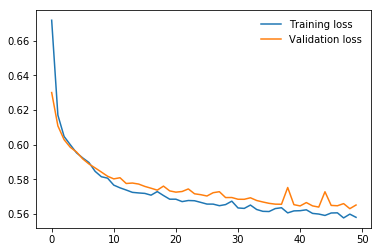

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(dev_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

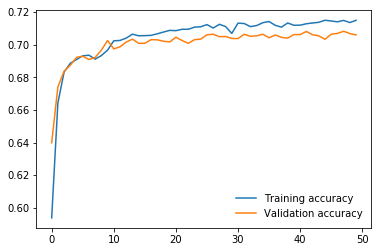

In [11]:
plt.plot(train_acc, label="Training accuracy")
plt.plot(dev_acc, label="Validation accuracy")
plt.legend(frameon=False)
plt.show()